This code is a pilot experiment for solving a regression problem using a Physics-Informed Neural Network (PINN). Here's a brief summary and explanation of the code:

    Data Loading and Preprocessing:
        It starts by loading a dataset from a CSV file (Wave_Current_ Speeds_TimeSeries(11.5m).csv).
        The dataset contains information about Wave Speed and Current Speed of 11.5 meters depth

    Data Splitting:
        It splits the dataset into training and testing sets, with 70% of the data used for training and30% for testing.

    Model Definition (PINN):
        It defines a PINN model using TensorFlow's Keras API.
        The model consists of two hidden layers with 32 neurons each and uses ReLU activation functions.
        The output layer has a single neuron, which will predict the Current Speed.

    Physics-Informed Loss Function:
        It defines a custom loss function called physics_loss.
        Inside this loss function, it uses TensorFlow's GradientTape to calculate gradients during training.
        The loss enforces a physics-based equation where the predicted Current Speed should be equal to the Wave Speed.

    Training Parameters:
        It sets the learning rate and the number of training epochs.

    Model Training:
        It creates an instance of the PINN model and an optimizer (Adam) for training.
        During the training loop, it iteratively minimizes the physics-informed loss by adjusting the model's weights.
        It stores the training loss at each epoch for plotting a learning curve.

    Learning Curve Visualization:
        After training, it plots the learning curve to show how the loss decreases over epochs.

    Results Visualization:
        It makes predictions on the test data and plots the results.
        The scatter plot shows the relationship between Wave Speed and Actual Current Speed.
        The color of each point on the scatter plot represents the Predicted Current Speed.
        The goal is to see how well the PINN model predicts the Current Speed based on the physics-based equation.

This work provides a starting point for building and training a PINN to forecast Current Speed based on Wave Speed. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:

data = pd.read_csv('Wave_Current_ Speeds_TimeSeries(1.5m).csv') 


In [3]:
X = data[['Wave Speed']].values  # Input: Wave Speed
y = data['Current speed'].values  # Output: Current Speed


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
class CurrentSpeedPINN(tf.keras.Model):
    def __init__(self):
        super(CurrentSpeedPINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')  # First hidden layer with 32 neurons and ReLU activation
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')  # Second hidden layer with 32 neurons and ReLU activation
        self.output_layer = tf.keras.layers.Dense(1)  # Output layer with one neuron for predicting Current Speed

    def call(self, inputs):
        x = self.dense1(inputs)  # Pass input through the first hidden layer
        x = self.dense2(x)  # Pass through the second hidden layer
        output = self.output_layer(x)  # Output prediction
        return output

In [7]:
def physics_loss(model, X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        predictions = model(X)  # Predict Current Speed based on Wave Speed
        wave_speed = X  # Extract Wave Speed
        current_speed_pred = predictions

        # Define a physics-based equation (customize as per the problem)
        physics_equation = current_speed_pred - wave_speed  # Predicted Current Speed should equal Wave Speed

    physics_loss_value = tf.reduce_mean(tf.square(physics_equation))  # Calculate the mean squared loss
    return physics_loss_value

In [8]:
# Define training hyperparameters
learning_rate = 0.001  # Learning rate for optimization
epochs = 10000 # Number of training epochs

model = CurrentSpeedPINN()
optimizer = tf.optimizers.Adam(learning_rate)

In [9]:
train_total_loss_curve = []  # Total loss (Data Loss + Physics Loss)
train_data_loss_curve = []  # Data Loss (MSE) component
train_physics_loss_curve = []  # Physics Loss component

In [11]:
# Training loop
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
        loss_value = physics_loss(model, X_train_tensor)
        y_train_pred = model(X_train_tensor)
        
        # Calculate data fitting (MSE) loss
        data_loss = mean_squared_error(y_train, y_train_pred.numpy())
        
        # Calculate training MSE and MAE
        train_mse = data_loss
        train_mae = mean_absolute_error(y_train, y_train_pred.numpy())
        total_loss = data_loss+ loss_value
    grads = tape.gradient(loss_value, model.trainable_variables)  # Use 'loss_value' here
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_total_loss_curve.append(loss_value.numpy()+data_loss)
    train_data_loss_curve.append(data_loss)
    train_physics_loss_curve.append(loss_value)  # You can use 'loss_value' as a placeholder for physics loss
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()+data_loss}, Data Loss (MSE): {data_loss}, Physics Loss: {loss_value}")


Epoch 0, Total Loss: 0.264213171754291, Data Loss (MSE): 0.0029386253694796117, Physics Loss: 0.2583359181880951
Epoch 100, Total Loss: 0.48410080489154295, Data Loss (MSE): 0.24120470997329194, Physics Loss: 0.0016913930885493755
Epoch 200, Total Loss: 0.502517261142901, Data Loss (MSE): 0.2512447615815911, Physics Loss: 2.773143569356762e-05
Epoch 300, Total Loss: 0.5042672075829957, Data Loss (MSE): 0.25212963600973826, Physics Loss: 7.939654096844606e-06
Epoch 400, Total Loss: 0.50464165377915, Data Loss (MSE): 0.25231883096993063, Physics Loss: 3.97961866838159e-06
Epoch 500, Total Loss: 0.5047954611779749, Data Loss (MSE): 0.2523964636327326, Physics Loss: 2.5289666609751293e-06
Epoch 600, Total Loss: 0.5048757767815576, Data Loss (MSE): 0.2524369931359277, Physics Loss: 1.781180458237941e-06
Epoch 700, Total Loss: 0.504923255348266, Data Loss (MSE): 0.2524609576702722, Physics Loss: 1.328772214037599e-06
Epoch 800, Total Loss: 0.5049513192448596, Data Loss (MSE): 0.2524751336846

Epoch 7000, Total Loss: 0.5048933735272041, Data Loss (MSE): 0.25244669226614147, Physics Loss: 9.421906810302971e-09
Epoch 7100, Total Loss: 0.5050778462867473, Data Loss (MSE): 0.25253892683789475, Physics Loss: 1.6928745072419815e-09
Epoch 7200, Total Loss: 0.5050737179212906, Data Loss (MSE): 0.25253685483268284, Physics Loss: 2.5713355888967726e-09
Epoch 7300, Total Loss: 0.5050584584234947, Data Loss (MSE): 0.25252922472941813, Physics Loss: 1.4057405239853438e-09
Epoch 7400, Total Loss: 0.504170570268204, Data Loss (MSE): 0.25208518256144746, Physics Loss: 2.109660783844447e-07
Epoch 7500, Total Loss: 0.5050660251281645, Data Loss (MSE): 0.25253300653914473, Physics Loss: 1.37853251036546e-09
Epoch 7600, Total Loss: 0.5051897668712211, Data Loss (MSE): 0.2525948786609244, Physics Loss: 6.488286796724196e-09
Epoch 7700, Total Loss: 0.5050383912608583, Data Loss (MSE): 0.2525192009494263, Physics Loss: 1.4509651258265421e-09
Epoch 7800, Total Loss: 0.5050677696820385, Data Loss (M

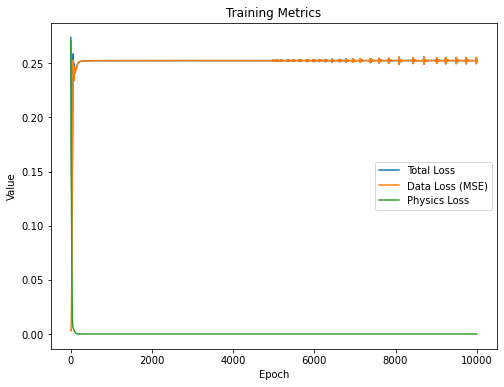

In [12]:
# Plot the learning curve to visualize the training progress
plt.figure(figsize=(8, 6))
plt.plot(train_total_loss_curve, label='Total Loss')
plt.plot(train_data_loss_curve, label='Data Loss (MSE)')
plt.plot(train_physics_loss_curve, label='Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.show()

In [13]:
print(f"Training MSE: {train_mse}, Training MAE: {train_mae}")

Training MSE: 0.25118465054544875, Training MAE: 0.4520567152072703


In [14]:
 # Make predictions on the test data
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_pred = model(X_test_tensor).numpy()


In [15]:
# Calculate testing metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {test_mse}, Test MAE: {test_mae}")

Test MSE: 0.2635306971011779, Test MAE: 0.4630928860961945


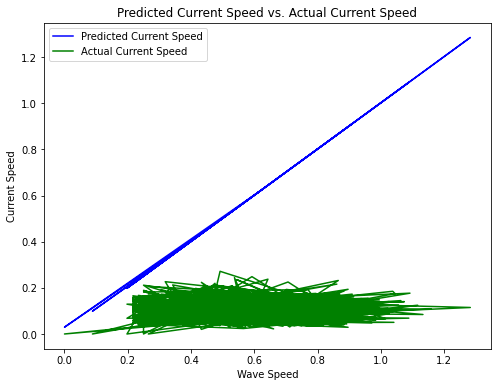

In [16]:
# Plot the results: Actual vs. Predicted Current Speed
plt.figure(figsize=(8, 6))
plt.plot(X_test[:, 0], y_pred[:, 0], label='Predicted Current Speed', color='blue')
plt.plot(X_test[:, 0], y_test, label='Actual Current Speed', color='green')
plt.xlabel('Wave Speed')
plt.ylabel('Current Speed')
plt.title('Predicted Current Speed vs. Actual Current Speed')
plt.legend()
plt.show()